In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency

In [2]:
# import cleaned dataset

df = pd.read_csv('esrb_dataset_clean.csv')
df.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,sum_descriptors,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,3,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,3,T


In [3]:
# summary statistics of ESRB ratings

df.groupby('esrb_rating')['sum_descriptors'].describe()

,count,mean,std,min,25%,50%,75%,max
esrb_rating,,,,,,,,
E,416.0,0.387019,0.569696,0.0,0.0,0.0,1.0,2.0
ET,402.0,1.771144,0.964385,1.0,1.0,1.0,2.0,5.0
M,387.0,3.031008,1.208377,1.0,2.0,3.0,4.0,6.0
T,689.0,2.258345,1.157643,1.0,1.0,2.0,3.0,6.0


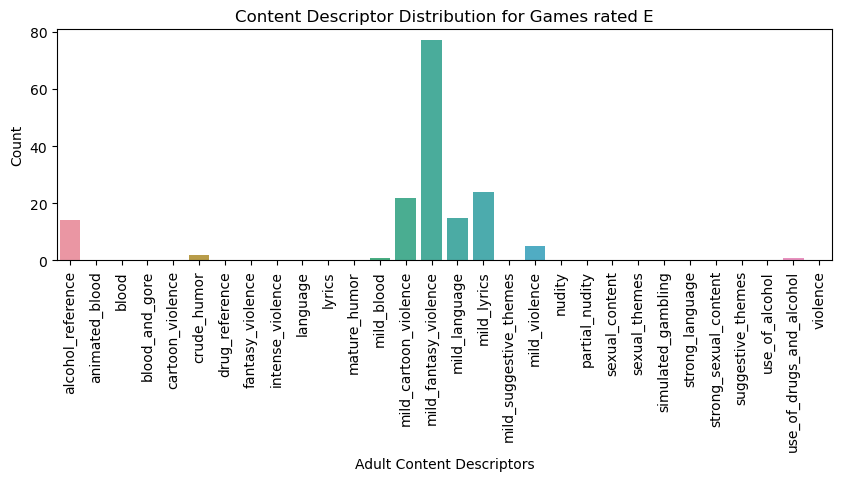

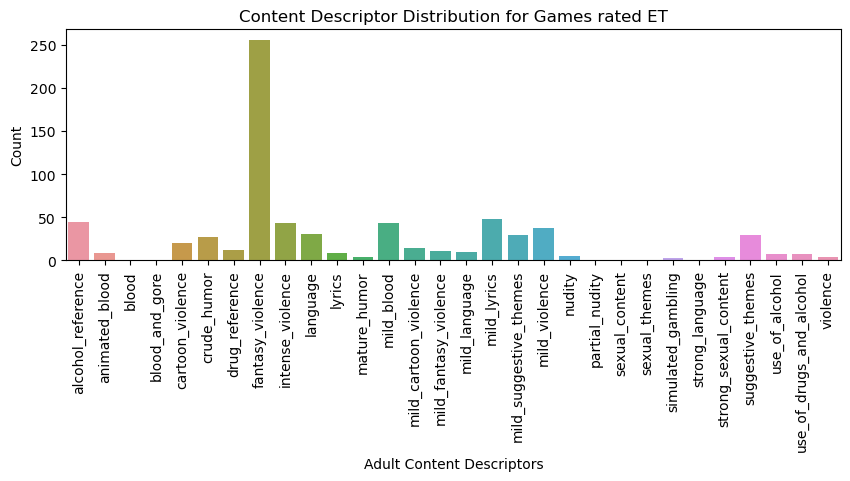

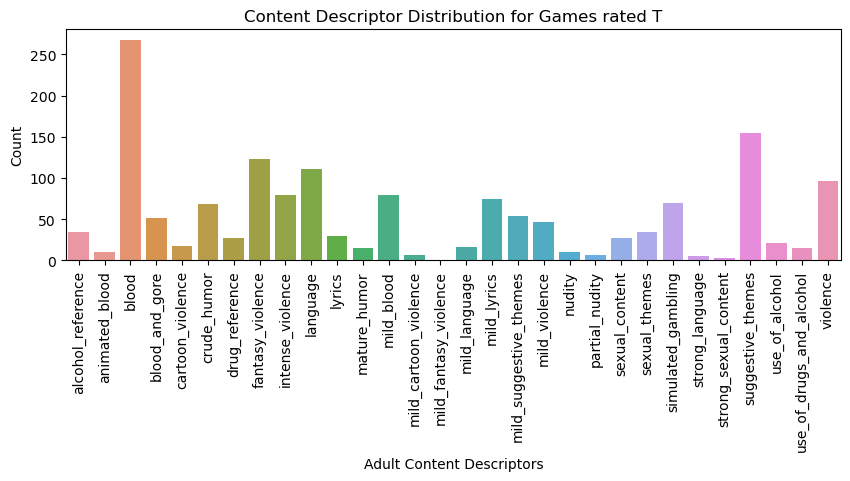

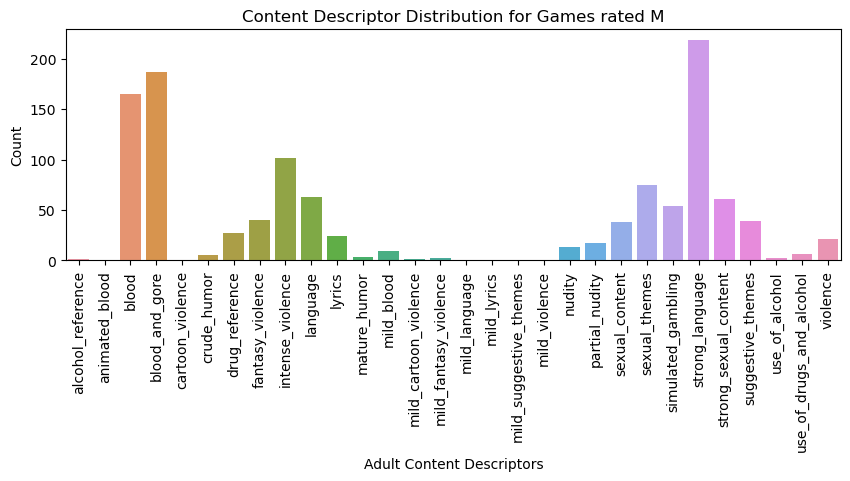

In [4]:
# distribution of descriptors, respective to the ratings

ratings = ['E','ET','T','M']

for rating in ratings:
    dfr = df[df['esrb_rating'] == rating].drop(columns = ['esrb_rating','title','console','sum_descriptors'], axis=1).sum()
    plt.figure(figsize=(10,3))
    sns.barplot(x=dfr.index, y=dfr.values)
    plt.xlabel('Adult Content Descriptors')
    plt.ylabel('Count')
    plt.title(f'Content Descriptor Distribution for Games rated {rating}')
    plt.xticks(rotation=90)
    plt.show()

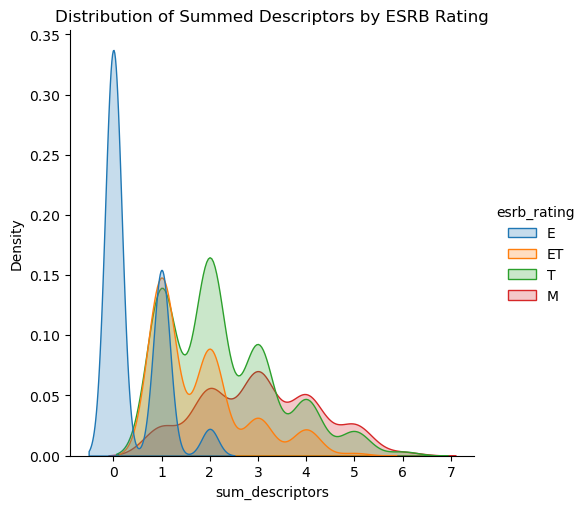

In [5]:
# plot KDE for sum_descriptors
_ = sns.displot(x="sum_descriptors", kind='kde',hue="esrb_rating", data=df, fill=True, hue_order=ratings, common_norm=True) # hue_order used to correctly sort the ratings in the figures
_ = plt.title('Distribution of Summed Descriptors by ESRB Rating')
_ = plt.show()

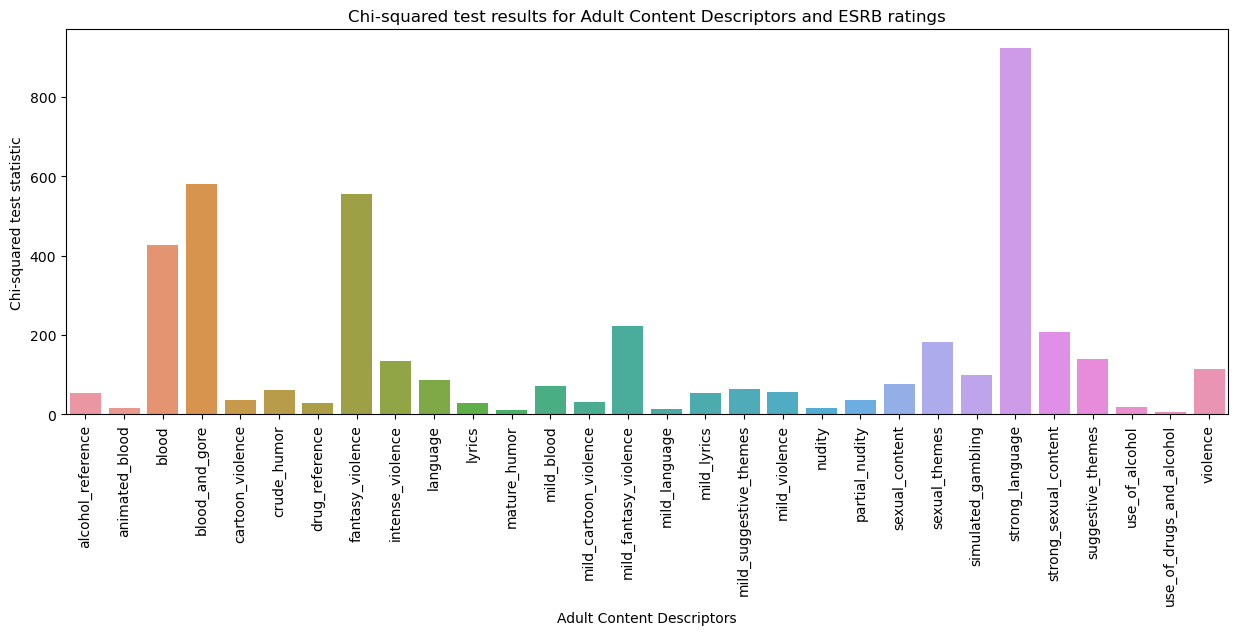

In [6]:
# perform chi-squared test between each feature and target variable (ESRB Rating)

chi2_results = []

for feature in df.columns[2:-2]:
    contingency_table = pd.crosstab(df[feature], df['esrb_rating'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append((feature, chi2, p_value))
    
# visualization
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=[r[0] for r in chi2_results], y=[r[1] for r in chi2_results], ax=ax )
ax.set_xlabel('Adult Content Descriptors')
ax.set_ylabel('Chi-squared test statistic')
ax.set_title('Chi-squared test results for Adult Content Descriptors and ESRB ratings')
plt.xticks(rotation=90)
plt.show()

• The results suggest that most binary features are significantly associated with the target variable, ESRB Rating.

• Columns like **strong_language, blood_and_gore, blood** and **fantasy_violence** are among the most strongly associated features.

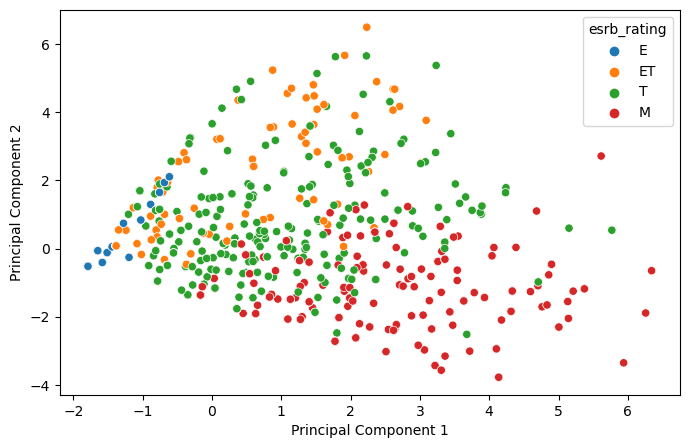

In [7]:
# PCA for 2D hyperspace visualization

X = df.drop(columns=['title','console','esrb_rating'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['esrb_rating'] = df['esrb_rating']

# visualize the results
_ = plt.figure(figsize=(8,5))
_ = sns.scatterplot(x='PC1', y='PC2', hue='esrb_rating', data=df_pca, hue_order=ratings)
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')

* Clusters for ratings **E and M** can be visualized separately. Our model should be able to correctly distinguish these ratings based on the features.
* Clusters for ratings **ET and T** appear to be overlapping. This could mean that our model may have trouble distinguishing between these ratings based on the features.
* Another possibility for this overlap may be due to the plot being 2D, and not a higher dimension. In any case, we can be more careful during the modelling phase.